In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set(style="darkgrid")
pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)

In [2]:
def get_nullframe(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    return pd.DataFrame({'feature':null_sum.index,'count':null_sum.values,
                          'null_percent':(null_sum.values/dataset.shape[0])*100}).sort_values(by=['count'],ascending=False)

In [3]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

In [4]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

In [5]:
from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

In [6]:
def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

In [7]:
def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [8]:
train=pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
test=pd.read_csv("test_Y3wMUE5_7gLdaTN.csv")

In [9]:
train_original=train.copy()
test_original=test.copy()

In [10]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [11]:
train['Loan_Status'].value_counts(normalize=True)

Y    0.6873
N    0.3127
Name: Loan_Status, dtype: float64

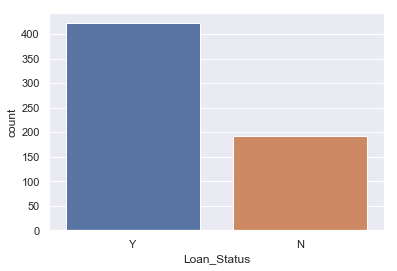

In [12]:
ax = sns.countplot(x="Loan_Status", data=train)

In [13]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [14]:
continuous_ds = train.select_dtypes(np.number)
continuous_columns = continuous_ds.columns.values.tolist()
continuous_columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [15]:
categorical_ds = train.select_dtypes("object")
categorical_columns = categorical_ds.columns.values.tolist()
ordinal_columns =['Dependents','Education','Property_Area']
categorical_columns = [ column for column in categorical_columns if column not in ordinal_columns ]
categorical_columns.remove('Loan_ID')

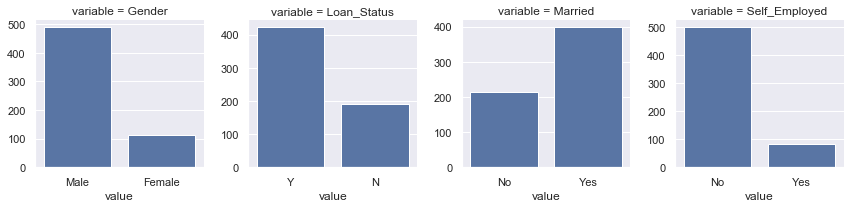

In [16]:
f = pd.melt(train, value_vars=sorted(categorical_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')

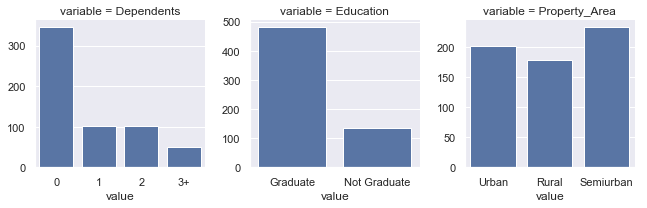

In [17]:
f = pd.melt(train, value_vars=sorted(ordinal_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')

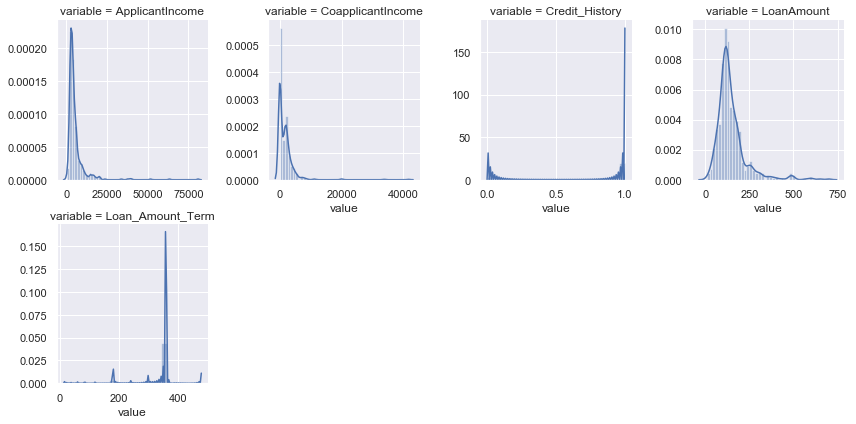

In [18]:
f = pd.melt(train, value_vars=sorted(continuous_ds))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

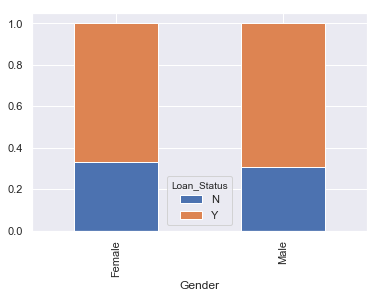

In [19]:
gender=pd.crosstab(train['Gender'],train['Loan_Status'])
gender.div(gender.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [20]:
train.groupby(['Gender','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Gender  Credit_History  Loan_Status
Female  0.0             N               16
                        Y                1
        1.0             N               20
                        Y               64
Male    0.0             N               63
                        Y                6
        1.0             N               75
                        Y              307
Name: Loan_ID, dtype: int64

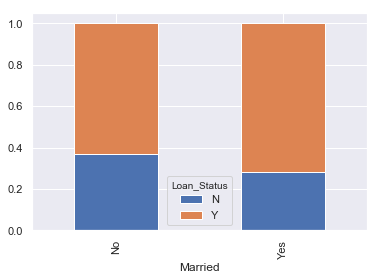

In [21]:
married=pd.crosstab(train['Married'],train['Loan_Status'])
married.div(married.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [22]:
train.groupby(['Married','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Married  Credit_History  Loan_Status
No       0.0             N               29
                         Y                3
         1.0             N               45
                         Y              122
Yes      0.0             N               53
                         Y                4
         1.0             N               52
                         Y              253
Name: Loan_ID, dtype: int64

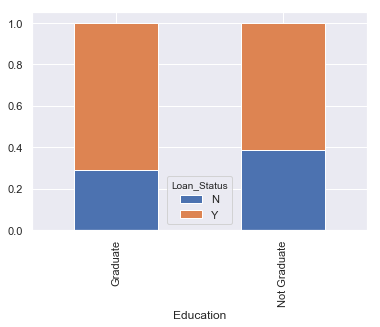

In [23]:
education=pd.crosstab(train['Education'],train['Loan_Status'])
education.div(education.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [24]:
train.groupby(['Education','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Education     Credit_History  Loan_Status
Graduate      0.0             N               57
                              Y                6
              1.0             N               73
                              Y              307
Not Graduate  0.0             N               25
                              Y                1
              1.0             N               24
                              Y               71
Name: Loan_ID, dtype: int64

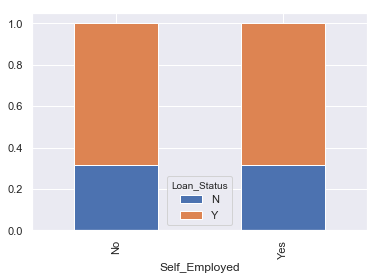

In [25]:
self_employed=pd.crosstab(train['Self_Employed'],train['Loan_Status'])
self_employed.div(self_employed.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [26]:
train.groupby(['Education','Self_Employed','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Education     Self_Employed  Credit_History  Loan_Status
Graduate      No             0.0             N               46
                                             Y                6
                             1.0             N               62
                                             Y              249
              Yes            0.0             N               10
                             1.0             N                9
                                             Y               41
Not Graduate  No             0.0             N               23
                                             Y                1
                             1.0             N               19
                                             Y               57
              Yes            0.0             N                2
                             1.0             N                4
                                             Y                9
Name: Loan_ID, dtype: int64

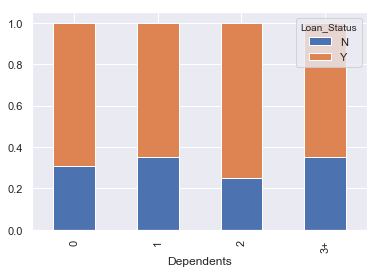

In [27]:
#Credit_History
dependents=pd.crosstab(train['Dependents'],train['Loan_Status'])
dependents.div(dependents.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [28]:
train.groupby(['Dependents','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Dependents  Credit_History  Loan_Status
0           0.0             N               42
                            Y                3
            1.0             N               60
                            Y              211
1           0.0             N               13
                            Y                1
            1.0             N               17
                            Y               59
2           0.0             N               13
                            Y                1
            1.0             N               12
                            Y               69
3+          0.0             N                9
                            Y                2
            1.0             N                7
                            Y               30
Name: Loan_ID, dtype: int64

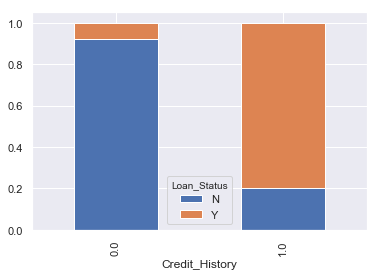

In [29]:
#Credit_History
Credit_History=pd.crosstab(train['Credit_History'],train['Loan_Status'])
Credit_History.div(Credit_History.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

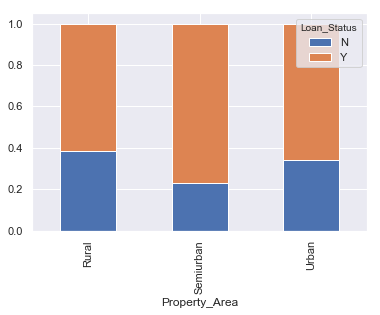

In [30]:
PropertyArea=pd.crosstab(train['Property_Area'],train['Loan_Status'])
PropertyArea.div(PropertyArea.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [31]:
train.groupby(['Property_Area','Loan_Status'])['Loan_ID'].count().reindex()

Property_Area  Loan_Status
Rural          N               69
               Y              110
Semiurban      N               54
               Y              179
Urban          N               69
               Y              133
Name: Loan_ID, dtype: int64

In [32]:
test[ (test['Credit_History'].notnull()) &(test['Dependents']!='0')]['Credit_History'].value_counts()

1.0    127
0.0     26
Name: Credit_History, dtype: int64

In [33]:
Credit_History_Married=pd.crosstab(train['Credit_History'],train['Married'],train['Loan_Status'],margins=True, aggfunc='count')
Credit_History_Married

Married,No,Yes,All
Credit_History,,,
0.0,32,57,89
1.0,167,305,472
All,199,362,561


In [34]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
6,Credit_History,50,8.1433
3,Self_Employed,32,5.2117
4,LoanAmount,22,3.5831
2,Dependents,15,2.4430
5,Loan_Amount_Term,14,2.2801
0,Gender,13,2.1173
1,Married,3,0.4886


In [35]:
test_null =get_nullframe(test)
test_null

,feature,count,null_percent
5,Credit_History,29,7.9019
2,Self_Employed,23,6.2670
0,Gender,11,2.9973
1,Dependents,10,2.7248
4,Loan_Amount_Term,6,1.6349
3,LoanAmount,5,1.3624


In [36]:
#train_credit_null_index = train[(train['Married']=='Yes') &
#                                (train['CoapplicantIncome']!=0) 
#                                &(train['Credit_History'].isnull())].index.tolist()
#test_credit_null_index=test[(test['Married']=='Yes') & 
#                            (test['CoapplicantIncome']!=0) &
#                            (test['Credit_History'].isnull())].index.tolist()

#train.loc[train_credit_null_index,'Credit_History']=1
#test.loc[test_credit_null_index,'Credit_History']=1

train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0], inplace=True)

train['Dependents'].fillna(train['Dependents'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)

 
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median(),inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(),inplace=True)
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Gender'].fillna(test['Gender'].mode()[0], inplace=True)

train_Married_null_index = train[ 
                                (train['CoapplicantIncome']!=0) 
                                &(train['Married'].isnull())].index.tolist()

train.loc[train_Married_null_index,'Married']='Yes'
train['Married'].fillna('No',inplace=True)

In [37]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
0,LoanAmount,22,3.5831


In [38]:
test_null =get_nullframe(test)
test_null

,feature,count,null_percent
0,LoanAmount,5,1.3624


In [39]:
def emi_calculator(row): 
    r = 8.7 / (12 * 100) # one month interest 
    return (row['LoanAmount']*1000 * r * pow(1 + r, row['Loan_Amount_Term'])) / (pow(1 + r, row['Loan_Amount_Term']) - 1) 
 

In [40]:
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)
full_dataset =pd.concat(objs=[train, test], axis=0,sort =True).reset_index(drop=True) 
table = full_dataset.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
def fage(x):
     return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
full_dataset['LoanAmount'].fillna(full_dataset[full_dataset['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [41]:
property_map = {'Rural':1,'Urban':2,'Semiurban':3}
full_dataset['TotalIncome'] =  full_dataset['ApplicantIncome'] + full_dataset['CoapplicantIncome']
full_dataset['HasCoApplicant'] = full_dataset['CoapplicantIncome'].apply(lambda x: "Y" if x > 0 else "N")
full_dataset['EMI'] = full_dataset.apply(emi_calculator,axis=1)
full_dataset['Balance_Income']= full_dataset['TotalIncome']-(full_dataset['EMI']) +1
full_dataset['Balance_ApplicantIncome']= full_dataset['ApplicantIncome']-(full_dataset['EMI']) +1
full_dataset['Married'] = (full_dataset['Married']=='Yes') * 1
full_dataset['Gender'] = (full_dataset['Gender']=='Male') * 1
full_dataset['Property_Area'] = full_dataset['Property_Area'].map(property_map)
full_dataset['LoanAmount']= full_dataset['LoanAmount']
full_dataset['ApplicantIncomeRatio'] = full_dataset['ApplicantIncome']/ full_dataset['LoanAmount']
full_dataset['TotalIncomeRatio'] = full_dataset['TotalIncome']/ full_dataset['LoanAmount']
full_dataset['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3),inplace=True)


In [42]:
#full_dataset['Loan_Amount_Term']= full_dataset['Loan_Amount_Term']/12
#full_dataset["Graduate_with_GoodCreditHistory"] = ((full_dataset["Education"] == "Graduate")& (full_dataset['Credit_History']=='1.0')) * 1
#full_dataset["Graduate_with_BadCreditHistory"] = ((full_dataset["Education"] == "Graduate")& (full_dataset['Credit_History'] =='0.0')) * 1
#full_dataset["NotGraduate_with_GoodCreditHistory"] = ((full_dataset["Education"] == "Not Graduate")& (full_dataset['Credit_History']=='1.0')) * 1
#full_dataset["NotGraduate_with_BadCreditHistory"] = ((full_dataset["Education"] == "Not Graduate")& (full_dataset['Credit_History'] =='0.0')) * 1
#full_dataset["Married_CoApplicant_NoDependents"] = ((full_dataset["Married"] == 1) & 
#                                                    (full_dataset['Dependents'] =='0')&
#                                                    (full_dataset['HasCoApplicant']=='Y')) * 1
#full_dataset["Married_NoDependents"] = ((full_dataset["Married"] == 1) & (full_dataset['Dependents'] ==0)) * 1
#full_dataset["Married_WithDependents"] = ((full_dataset["Married"] == 1) & (full_dataset['Dependents'] !=0)) * 1
#full_dataset["NotMarried_NoDependents"] = ((full_dataset["Married"] == 0) & (full_dataset['Dependents'] ==0)) * 1
#full_dataset["NotMarried_WithDependents"] = ((full_dataset["Married"] == 0) & (full_dataset['Dependents'] !=0)) * 1
full_dataset.head()


,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio
0,5849,0.0,1.0,0,Graduate,1,130.0,360.0,LP001002,1.0,0,2,No,5849.0,N,1018.0717,4831.9283,4831.9283,44.9923,44.9923
1,4583,1508.0,1.0,1,Graduate,1,128.0,360.0,LP001003,0.0,1,1,No,6091.0,Y,1002.4090,5089.5910,3581.5910,35.8047,47.5859
2,3000,0.0,1.0,0,Graduate,1,66.0,360.0,LP001005,1.0,1,2,Yes,3000.0,N,516.8672,2484.1328,2484.1328,45.4545,45.4545
3,2583,2358.0,1.0,0,Not Graduate,1,120.0,360.0,LP001006,1.0,1,2,No,4941.0,Y,939.7585,4002.2415,1644.2415,21.5250,41.1750
4,6000,0.0,1.0,0,Graduate,1,141.0,360.0,LP001008,1.0,0,2,No,6000.0,N,1104.2162,4896.7838,4896.7838,42.5532,42.5532


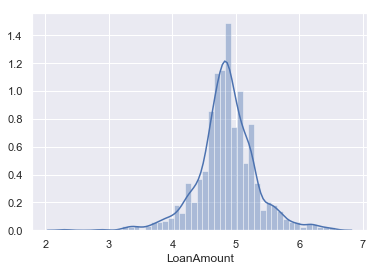

In [43]:
sns.distplot(np.log1p(full_dataset['LoanAmount']))

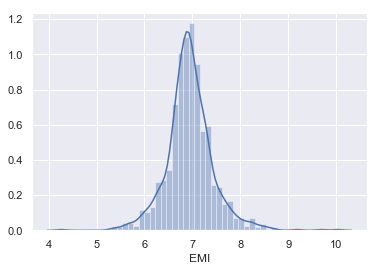

In [44]:
sns.distplot(np.log1p(full_dataset['EMI']))

In [45]:
cat_list = [column for column in  full_dataset.columns if column not in full_dataset.describe(include=[np.number]).columns.values.tolist()]
cat_list.remove('Loan_ID') 

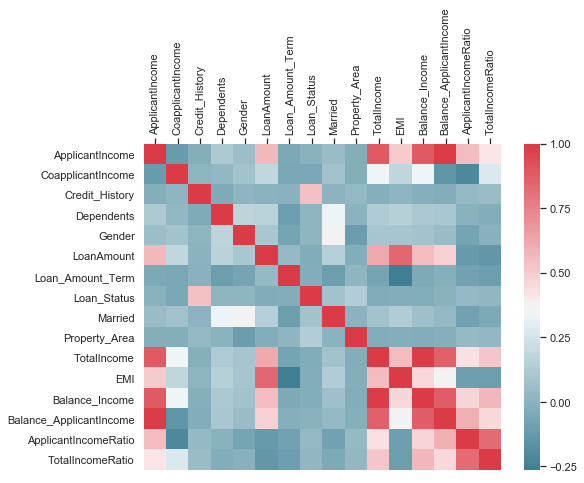

In [46]:
correlation = full_dataset[full_dataset['Loan_Status'].notnull()][full_dataset.describe(include=[np.number]).columns.values.tolist()].corr()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, 
           xticklabels=correlation.columns.values,
           yticklabels=correlation.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

#correlation = correlation.sort_values('Loan_Status', ascending=False)
#plt.figure(figsize=(8,10))
#sns.barplot( correlation['Loan_Status'][1:], correlation.index[1:], orient='h')
#plt.show()

In [47]:
train_Id  = full_dataset[full_dataset['Loan_Status'].notnull()]["Loan_ID"]
test_Id = full_dataset[full_dataset['Loan_Status'].isnull()]["Loan_ID"]
full_dataset.drop(['Loan_ID','CoapplicantIncome','TotalIncome', 
                   'Balance_Income','ApplicantIncome'],axis=1,inplace=True)

In [48]:
full_dataset = pd.get_dummies(full_dataset, prefix_sep='_', drop_first=False)

In [49]:
full_dataset.drop([ 'Education_Not Graduate','Self_Employed_No' ,'HasCoApplicant_N'],axis=1,inplace=True)

In [50]:
from datatools.customtransformers import StdScaleTransformer,RobustScaleTransformer,MinMaxTransformer,LogTransformer
scaler = LogTransformer(['EMI','LoanAmount'])
full_dataset =scaler.fit_transform(full_dataset)

In [51]:
def evaluvate_model(clf ,X_trainmodel, y_trainmodel,X_val,y_val): 
    clf.fit(X_trainmodel, y_trainmodel.values.ravel())
    train_sizes, train_scores, validation_scores = learning_curve(clf, 
                                                                  X_trainmodel,y_trainmodel.values.ravel(),cv=kfold)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    plot_roc(X_val,y_val,clf)
    y_pred=measure_performance(X_val,y_val,clf, show_accuracy=False, 
                               show_classification_report=True,
                               show_confusion_matrix=True, show_r2_score=False)



In [52]:
null_dataset =get_nullframe(full_dataset)
null_dataset

,feature,count,null_percent
0,Loan_Status,367,37.4108


In [53]:
train_X = full_dataset[full_dataset['Loan_Status'].notnull()] 
test_X = full_dataset[full_dataset['Loan_Status'].isnull()]  
train_y= full_dataset[full_dataset['Loan_Status'].notnull()]['Loan_Status']
train_X.drop(['Loan_Status'],axis=1,inplace=True)
test_X.drop(['Loan_Status'],axis=1,inplace=True)

In [54]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.25
seed = 42
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)
kfold = StratifiedKFold(n_splits=10)

(614, 14)
(367, 14)


In [55]:
X_trainmodel.head()

,Credit_History,Dependents,Gender,LoanAmount,Loan_Amount_Term,Married,Property_Area,EMI,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio,Education_Graduate,Self_Employed_Yes,HasCoApplicant_Y
92,1.0,2,1,4.4067,360.0,1,2,6.4542,2639.6630,40.4074,62.8765,0,0,1
304,1.0,0,1,4.9488,360.0,0,1,7.0007,2904.6151,28.5714,46.4286,1,0,1
68,1.0,3,1,4.8363,60.0,1,2,7.8546,4524.3677,56.8000,56.8000,0,1,0
15,1.0,0,1,4.8363,360.0,0,2,6.8875,3972.0849,39.6000,39.6000,1,0,0
211,0.0,3,1,4.8598,360.0,1,3,6.9112,2428.5910,26.7969,36.5625,1,0,1


Accuracy: 77.273
Accuracy: 82.609


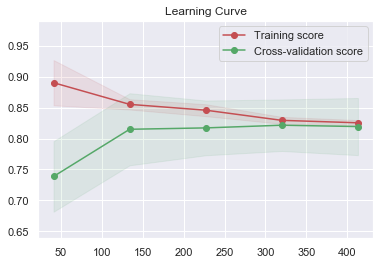

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best Penalty: l1
Best C: 4.641588833612778
Accuracy: 82.391


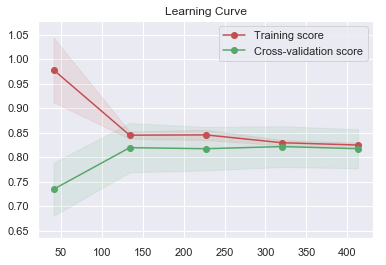

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e+00, 4.64159e+00, 2.15443e+01, 1.00000e+02, 4.64159e+02,
       2.15443e+03, 1.00000e+04, 4.64159e+04, 2.15443e+05, 1.00000e+06]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
Classification report
              precision    recall  f1-score   support

         0.0       0.88      0.39      0.54        54
         1.0       0.75      0.97      0.84       100

   micro avg       0.77      0.77      0.77       154
   macro avg       0.81      0.68      0.69       154
weighted avg      

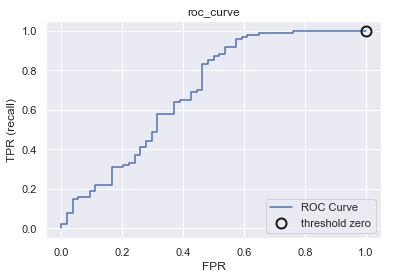

In [56]:
from sklearn.linear_model import LogisticRegression
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel, y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))
logrmodel ,result = test_classifier(logrmodel,X_trainmodel,y_trainmodel,kfold)
print(logrmodel)

# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 6, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
clf = GridSearchCV(logrmodel, hyperparameters, cv=5, verbose=0,scoring='accuracy')
best_model = clf.fit(X_trainmodel, y_trainmodel.values.ravel())
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

best_lr_model ,result = test_classifier(best_model,X_trainmodel,y_trainmodel,kfold)
print(best_lr_model)

y_pred=measure_performance(X_val,y_val,best_lr_model, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

plot_roc(X_val,y_val,best_lr_model)

In [57]:
from xgboost.sklearn import XGBClassifier

In [58]:
xgbr = XGBClassifier(n_estimators=100, silent=False)
xgbr.fit(X_trainmodel ,y_trainmodel.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [59]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Accuracy: 89.130


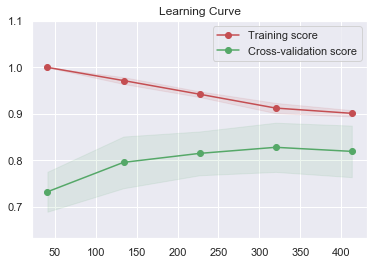

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)


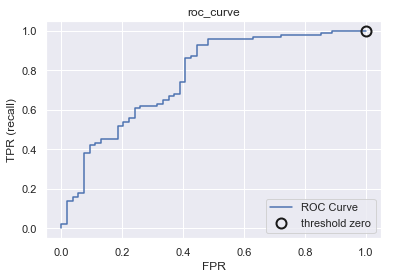

In [60]:
best_model ,result = test_classifier(xgbr,X_trainmodel,y_trainmodel,kfold)
print(best_model)

plot_roc(X_val,y_val,best_model)



In [61]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

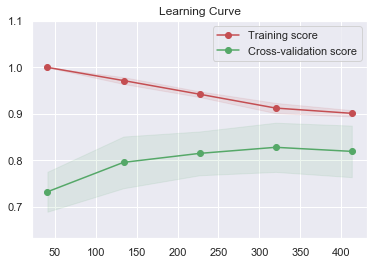

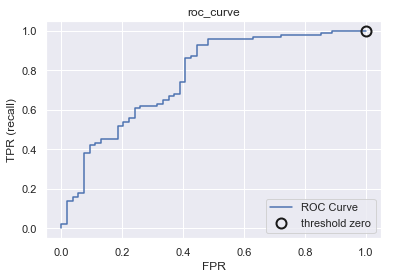

Classification report
              precision    recall  f1-score   support

         0.0       0.80      0.52      0.63        54
         1.0       0.78      0.93      0.85       100

   micro avg       0.79      0.79      0.79       154
   macro avg       0.79      0.72      0.74       154
weighted avg       0.79      0.79      0.77       154

Confusion matrix
[[28 26]
 [ 7 93]]


In [62]:
evaluvate_model(xgbr,X_trainmodel, y_trainmodel,X_val,y_val)

In [63]:
 def calc_accuracy(predictions, y_test):
    labels = y_test.get_label()
    return 'accuracy_score', (1 - sum(labels != predictions)/len(labels))

In [64]:
import xgboost as xgb

In [78]:
params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.1,
          "max_depth": 3,
          "subsample": 0.7,
          'colsample_bylevel': 1,
          'gamma': 0,
          'min_child_weight': 1,
          "silent": 1,
          "subsample":0.7,
          }

num_boost_round =60

In [79]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, watchlist, feval=calc_accuracy, maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.163043	eval-merror:0.214286	train-accuracy_score:0.836957	eval-accuracy_score:0.785714
Multiple eval metrics have been passed: 'eval-accuracy_score' will be used for early stopping.

Will train until eval-accuracy_score hasn't improved in 50 rounds.
[1]	train-merror:0.158696	eval-merror:0.214286	train-accuracy_score:0.841304	eval-accuracy_score:0.785714
[2]	train-merror:0.158696	eval-merror:0.214286	train-accuracy_score:0.841304	eval-accuracy_score:0.785714
[3]	train-merror:0.16087	eval-merror:0.214286	train-accuracy_score:0.83913	eval-accuracy_score:0.785714
[4]	train-merror:0.158696	eval-merror:0.214286	train-accuracy_score:0.841304	eval-accuracy_score:0.785714
[5]	train-merror:0.16087	eval-merror:0.214286	train-accuracy_score:0.83913	eval-accuracy_score:0.785714
[6]	train-merror:0.158696	eval-merror:0.214286	train-accuracy_score:0.841304	eval-accuracy_score:0.785714
[7]	train-merror:0.158696	eval-merror:0.207792	train-accuracy_score:0.841304	

In [67]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

In [68]:
import operator
create_feature_map(X_trainmodel)

Text(0.5,0,'relative importance')

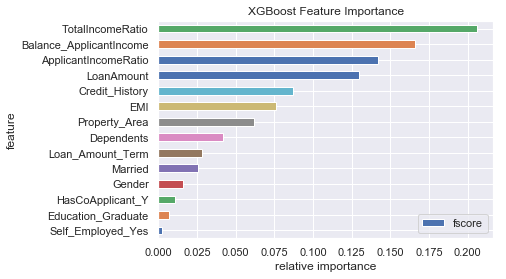

In [69]:
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_importances = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_importances['fscore'] = df_importances['fscore'] / df_importances['fscore'].sum()

df_importances.plot(kind='barh', x='feature', y='fscore')
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [70]:
test_y  =gbm.predict(xgb.DMatrix(test_X))

In [71]:
 
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_XgBooost"+timestamp+"_out.csv"

In [72]:
submission.to_csv(filename)

### Public Leaderboard - Practice Problem: Loan Prediction III
### Rank 156/35442		KrishnaMohan	0.8055555556

Accuracy: 88.261


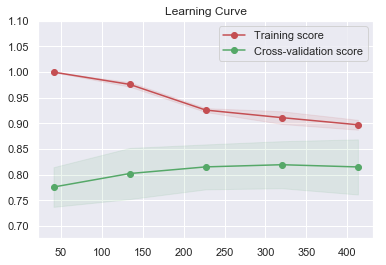

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=10,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=6,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              n_iter_no_change=None, presort='auto', random_state=2,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Classification report
              precision    recall  f1-score   support

         0.0       0.83      0.54      0.65        54
         1.0       0.79      0.94      0.86       100

   micro avg       0.80      0.80      0.80       154
   macro avg       0.81      0.74      0.76       154
weighted avg       0.80      0.80      0.79       154

Confusion matrix
[[29 25]
 [ 6 94]]


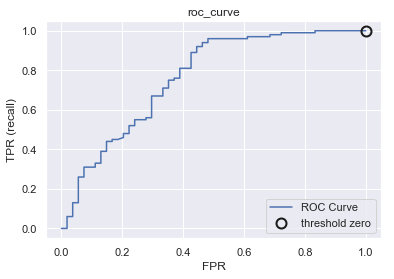

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
original_params = {'n_estimators':40, 'max_leaf_nodes':10, 'max_depth': 3, 'random_state': 2,
                   'min_samples_split':6,'min_samples_leaf':5,'learning_rate':0.1 }

gbc =GradientBoostingClassifier(**original_params)
gbc.fit(X_trainmodel, y_trainmodel.values.ravel())
 
best_gc =  gbc
best_gc ,result = test_classifier(best_gc,X_trainmodel,y_trainmodel,kfold)
print(best_gc)

y_pred=measure_performance(X_val,y_val,best_gc, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

plot_roc(X_val,y_val,best_gc)

In [74]:
test_y =best_gc.predict(test_X)

In [75]:
Checkpoint

NameError: name 'Checkpoint' is not defined

In [77]:
gbm?

In [80]:
def model_fit(alg,X_trainmodel, y_trainmodel,X_val, y_val,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds)
        
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(X_trainmodel, y_trainmodel,eval_metric='auc')
    dtrain_predictions = alg.predict(X_val)
    dtrain_predprob = alg.predict_proba(X_val)[:,1]
        #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_val.values, dtrain_predictions))
    print ("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val, dtrain_predprob))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.7922
AUC Score (Validation): 0.772500


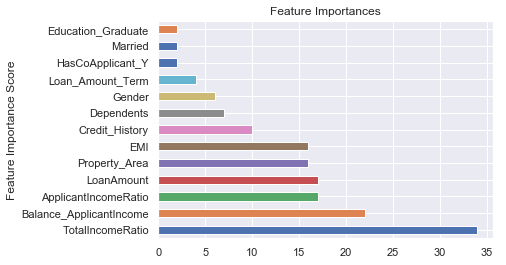

In [100]:
xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
model_fit(xgb1,X_trainmodel, y_trainmodel,X_val, y_val)

In [108]:
param_test1 = { 'max_depth':list(range(3,12,3)), 'min_child_weight':list(range(1,7,2))}
gsearch1 = GridSearchCV(estimator = xgb1,param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_trainmodel, y_trainmodel)
print(gsearch1.best_score_)
print(gsearch1.best_params_)
best_model = gsearch1.best_estimator_ 
print(best_model)

0.80385254502442
{'max_depth': 9, 'min_child_weight': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)


In [109]:

param_test5 = {
 'subsample':[i/100.0 for i in range(80,105,5)],
 'colsample_bytree':[i/100.0 for i in range(60,105,5)]
}
gsearch2 = GridSearchCV(estimator = best_model,param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_trainmodel, y_trainmodel)
print(gsearch2.best_score_)
print(gsearch2.best_params_)
best_model = gsearch2.best_estimator_ 
print(best_model)

0.8043370662901912
{'colsample_bytree': 0.95, 'subsample': 0.9}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.9)


In [112]:
param_test6 = {
 'reg_alpha':[0.1,0.2,0.03,0.05]
}
gsearch3= GridSearchCV(estimator = best_model,param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_trainmodel, y_trainmodel)
print(gsearch3.best_score_)
print(gsearch3.best_params_)
best_model = gsearch3.best_estimator_ 
print(best_model)

0.8107869416463167
{'reg_alpha': 0.1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.9)


In [ ]:
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_GradientBoosting"+timestamp+"_out.csv"

submission.to_csv(filename)